## Basic Morphing Routine

In this notebook you will find the fundamental operations for the morphing workflow that this package was set up to deliver. 

## Local Dev

These imports are only necssary if you are working from a local copy of the development github.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = "/Users/jmccarty/GitHub/pyepwmorph"
if module_path not in sys.path:
    sys.path.append(module_path)

## Imports

In [89]:
from pyepwmorph.tools import utilities as morph_utils
from pyepwmorph.tools import io as morph_io
from pyepwmorph.tools import configuration as morph_config
from pyepwmorph.models import access, coordinate, assemble
from pyepwmorph.tools import workflow as morph_work
from pyepwmorph.morph import procedures as morph_proc

import matplotlib.pyplot as plt

## Config Object

We recommend making using of the configuration object (tools.configuration.MorphConfig) to manage the workflow.

In [4]:
# set the project name, this will be used at the end for naming your files
project_name = "first_morph_project"

# input the filepath for the baseline EPW file that you are morphing
baseline_epw_file = "USA_MO_Whiteman.AFB.724467_TMY3.epw"

# set a list of user variables from the following:
# ['Temperature','Humidity','Pressure','Wind','Clouds and Radiation', 'Dew Point']
user_variables = ['Temperature', 'Humidity','Pressure', 'Wind', 'Clouds and Radiation', 'Dew Point']

# set a list of climate model pathways from the following:
# ['Best Case Scenario','Middle of the Road','Worst Case Scenario']
user_pathways = ['Best Case Scenario','Middle of the Road','Worst Case Scenario']

# choose the percentiles that you want to extract data from
percentiles = [1,50,99]

# tell the config object which future years to center on
future_years = [2050,2070]

# detect the basseline periiod from the baseline epw
baseepw = morph_io.Epw(baseline_epw_file)
baseline = baseepw.detect_baseline_range()

# set up an output directory (in this case it is relative to this notebook)
output_directory = "results"

In [5]:
# first set up the config object to pass important values to the functions
config_object = morph_config.MorphConfig(project_name, 
                                         baseline_epw_file,  
                                         user_variables, 
                                         user_pathways, 
                                         percentiles,
                                         future_years,
                                         output_directory,
                                         model_sources=None, # Empty for now, use the three default in the model
                                         baseline_range=baseline # This was detected form the EPW's baseline range but could be any tuple of two years
                                         ) 

## Morph One Variable

In [10]:
# getting the climate model from google cloud and into a clean ensemble dataframe takes three steps:

# 1. download the raw data for each model under a specified pathway and for a specific vairable
dataset_dict = access.access_cmip6_data(config_object.model_sources,
                                        # in the larger workflow normally you would iterate through all of your pathways. lets start with Best Case Scenario 
                                        "ssp126", # the config object takes the user pathway and makes a short string, for Best Case Scenario thats ssp126
                                        # in the larger workflow normally you would iterate through all of your variables. lets start with one 'pressure'
                                        "psl" # similar to the shortening of pathways, the config object creates a second lsit of variables pressure=psl
                                        )




--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [11]:
# this returns a dataset of xarrays where each key in the dict is the model sources
# this is just the first member of the dict
dataset_dict[list(dataset_dict.keys())[0]]

<xarray.Dataset>
Dimensions:         (lat: 144, bnds: 2, lon: 192, member_id: 1,
                     dcpp_init_year: 1, time: 3432)
Coordinates:
  * lat             (lat) float64 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon             (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time            (time) int64 0 708 1416 2148 ... 2504808 2505540 2506272
    time_bnds       (time, bnds) float64 dask.array<chunksize=(3432, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: bnds
Data variables:
    psl             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 713, 144, 192), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             60265.0
    branch_time_in_parent:            60265.0
    cmor_version:                     3.4.0
    ...                               ...
    intake_esm_attrs:variable_id:     psl
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCC...
    intake_esm_attrs:version:         20210317
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp...

In [12]:
# 2. Next the models need to be cleaned up a bit and given the same index, with some extra dimensions removed
# also the dataset will be constrained to the specific location of the epw file
dataset_dict = coordinate.coordinate_cmip6_data(config_object.epw.location['latitude'],
                                                config_object.epw.location['longitude'],
                                                "ssp126", 
                                                "psl",
                                                dataset_dict # this is the dict from the access step
                                                )


In [13]:
# the cleaner view of the first model source
dataset_dict[list(dataset_dict.keys())[0]]

<xarray.Dataset>
Dimensions:  (time: 1032)
Coordinates:
    lat      float64 -89.38
    lon      float64 38.44
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2100-12-01
    year     (time) int64 2015 2015 2015 2015 2015 ... 2100 2100 2100 2100 2100
Data variables:
    psl      (time) float32 1.003e+05 9.959e+04 9.96e+04 ... 9.925e+04 9.959e+04
Attributes: (12/63)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             60265.0
    branch_time_in_parent:            60265.0
    cmor_version:                     3.4.0
    ...                               ...
    intake_esm_attrs:variable_id:     psl
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCC...
    intake_esm_attrs:version:         20210317
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp...

In [14]:
# 3. Take the multiple models contianed in the dict and create a single ensemble from them using xclim
psl_ssp126_ensemble = assemble.build_cmip6_ensemble(config_object.percentiles, # tell the function where to slice the ensemble
                                                    "psl", # this is needed for some naming
                                                    dataset_dict # the dataset from the coordinate step
                                                    )

In [15]:
# now the dict has been replaced with a dataframe holding a monthly timeseries and all of the percentiles that were specified
psl_ssp126_ensemble

,1,50,99
time,,,
2015-01-01,99596.982500,99873.281250,100319.640625
2015-02-01,99607.017500,100355.125000,101793.765000
2015-03-01,99433.260313,99595.312500,102741.319219
2015-04-01,99646.964531,100830.414062,102606.273594
2015-05-01,99684.410937,100359.921875,102769.902656
...,...,...,...
2100-08-01,99838.516406,100099.632812,104243.202969
2100-09-01,99385.277969,99714.335938,102519.249062
2100-10-01,99028.299531,99336.976562,101012.470312


In [17]:
# in order to morph the pressure variable you will need the historical data from the climate models too
# you can repeat the previous steps bu for the historical pathway using a conveinence function from the workflows module
psl_historical_ensemble = morph_work.compile_climate_model_data(
    config_object.model_sources,
    "historical",
    "psl",
    config_object.epw.location["latitude"],
    config_object.epw.location["longitude"],
    config_object.percentiles,
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [20]:
# the same dataframe strucutre is then created for the historical pathway with a different set of dates for the index
psl_historical_ensemble

,1,50,99
time,,,
1960-01-01,102223.319844,102312.875000,102531.468594
1960-02-01,101882.791875,102295.218750,102551.251406
1960-03-01,101265.910000,101996.117188,102372.934844
1960-04-01,101406.768906,101467.031250,102032.828125
1960-05-01,101322.204531,101324.187500,101505.380312
...,...,...,...
2014-08-01,101419.655313,101530.625000,101626.144375
2014-09-01,101630.716563,101776.078125,101975.921563
2014-10-01,101831.815312,101945.265625,102163.300312


In [28]:
# choose one of the future years and set up a future range to gather the data to perofrm the delta calcs to the historical 
fut_year = config_object.future_years[0]
future_range = morph_utils.calc_period(int(fut_year), config_object.baseline_range)
print(config_object.baseline_range, future_range)

(1973, 2005) (2034, 2066)


In [56]:

# using the historical data and the pathway data for specific percentile construct the climatolgies based on the baseline range and future range
psl_climatologies = assemble.calc_model_climatologies(config_object.baseline_range, 
                                                      future_range,
                                                        psl_historical_ensemble[50],
                                                        psl_ssp126_ensemble[50],
                                                        'psl')


In [58]:
# The calc climatologies function reutrns a tuple of two series. the first is the monthly mean value for the historical data and the second is for the future
psl_climatologies

(time
 1     102594.866951
 2     102496.957860
 3     102098.445076
 4     101621.554924
 5     101536.474432
 6     101555.646780
 7     101595.567708
 8     101711.829782
 9     101834.554688
 10    101874.895123
 11    102045.004261
 12    102388.847538
 Name: psl, dtype: float64,
 time
 1      99855.095644
 2     100196.567472
 3     100177.859138
 4     100160.455966
 5     100171.302794
 6     100335.227983
 7     100348.711174
 8     100168.125237
 9      99968.186316
 10     99761.286695
 11     99672.099195
 12     99547.382812
 Name: psl, dtype: float64)

In [57]:
# extract the present day psl from the EPW
present_psl = config_object.epw.dataframe["atmos_Pa"]

# morph the preesnt day using the climatologies
morphed_psl = morph_proc.morph_psl(
    present_psl, psl_climatologies[1], psl_climatologies[0]
).values

array([96260, 96160, 96360, ..., 96459, 96459, 96459])

## Morphing Workflow

Repeating the above workflow for every variable, pathway, and percentile would be a bit cumbersome. Thus you can use the workflows.

In [287]:
# first build a new config object

# set the project name, this will be used at the end for naming your files
project_name = "second_morph_project"

# input the filepath for the baseline EPW file that you are morphing
baseline_epw_file = "USA_MO_Whiteman.AFB.724467_TMY3.epw"

# set a list of user variables from the following:
# ['Temperature','Humidity','Pressure','Wind','Clouds and Radiation', 'Dew Point']
user_variables = ['Temperature', 'Humidity','Pressure', 'Wind', 'Clouds and Radiation', 'Dew Point']

# set a list of climate model pathways from the following:
# ['Best Case Scenario','Middle of the Road','Worst Case Scenario']
user_pathways = ['Best Case Scenario','Middle of the Road','Worst Case Scenario']

# choose the percentiles that you want to extract data from
percentiles = [1,50,99]

# tell the config object which future years to center on
future_years = [2020,2050,2070]

# detect the basseline periiod from the baseline epw
baseepw = morph_io.Epw(baseline_epw_file)
baseline = baseepw.detect_baseline_range()

# set up an output directory (in this case it is relative to this notebook)
output_directory = "results"

# set up config object
config_object = morph_config.MorphConfig(project_name, 
                                         baseline_epw_file,  
                                         user_variables, 
                                         user_pathways, 
                                         percentiles,
                                         future_years,
                                         output_directory,
                                         model_sources=None, # Empty for now, use the three default in the model
                                         baseline_range=baseline # This was detected form the EPW's baseline range but could be any tuple of two years
                                         ) 

In [ ]:
# get climate model data into a single dict
year_model_dict = morph_work.iterate_compile_model_data(
    config_object.model_pathways,
    config_object.model_variables,
    config_object.model_sources,
    config_object.epw.location["longitude"],
    config_object.epw.location["latitude"],
    config_object.percentiles,
)

In [294]:
# set an empty dict to gather the results into
result_data = {}

for fut_year in config_object.future_years:
    fut_key = str(fut_year)
    result_data[fut_key] = {}
    future_range = morph_utils.calc_period(int(fut_year), config_object.baseline_range)
    for pathway in [
        pathway for pathway in config_object.model_pathways if pathway != "historical"
    ]:
        result_data[fut_key][pathway] = {}
        for percentile in config_object.percentiles:
            percentile_key = str(percentile)
            print(f"{fut_key}, {pathway}, {percentile}")
            morphed_data = morph_work.morph_epw(
                config_object.epw,
                config_object.user_variables,
                config_object.baseline_range,
                future_range,
                year_model_dict,
                pathway,
                percentile,
            )
            result_data[fut_key][pathway][percentile_key] = morphed_data

2020, ssp585, 1
Index(['apparent_zenith', 'zenith', 'apparent_elevation', 'elevation',
       'azimuth', 'equation_of_time', 'hour', 'doy', 'local_time_meridian',
       'time_correction', 'local_solar_time'],
      dtype='object')
2020, ssp585, 50
Index(['apparent_zenith', 'zenith', 'apparent_elevation', 'elevation',
       'azimuth', 'equation_of_time', 'hour', 'doy', 'local_time_meridian',
       'time_correction', 'local_solar_time'],
      dtype='object')
2020, ssp585, 99
Index(['apparent_zenith', 'zenith', 'apparent_elevation', 'elevation',
       'azimuth', 'equation_of_time', 'hour', 'doy', 'local_time_meridian',
       'time_correction', 'local_solar_time'],
      dtype='object')
2020, ssp245, 1
Index(['apparent_zenith', 'zenith', 'apparent_elevation', 'elevation',
       'azimuth', 'equation_of_time', 'hour', 'doy', 'local_time_meridian',
       'time_correction', 'local_solar_time'],
      dtype='object')
2020, ssp245, 50
Index(['apparent_zenith', 'zenith', 'apparent_elevati

In [302]:
# this workflow adds to this nested dict an epw object whihc contains a dataframe with the morphed fields
# this can be easily written to an epw file
morphed_data = result_data[fut_key][pathway][percentile_key]
morphed_data.write_to_file(os.path.join(config_object.output_directory,f"{fut_key}_{pathway}_{percentile_key}.epw"))

## Plots

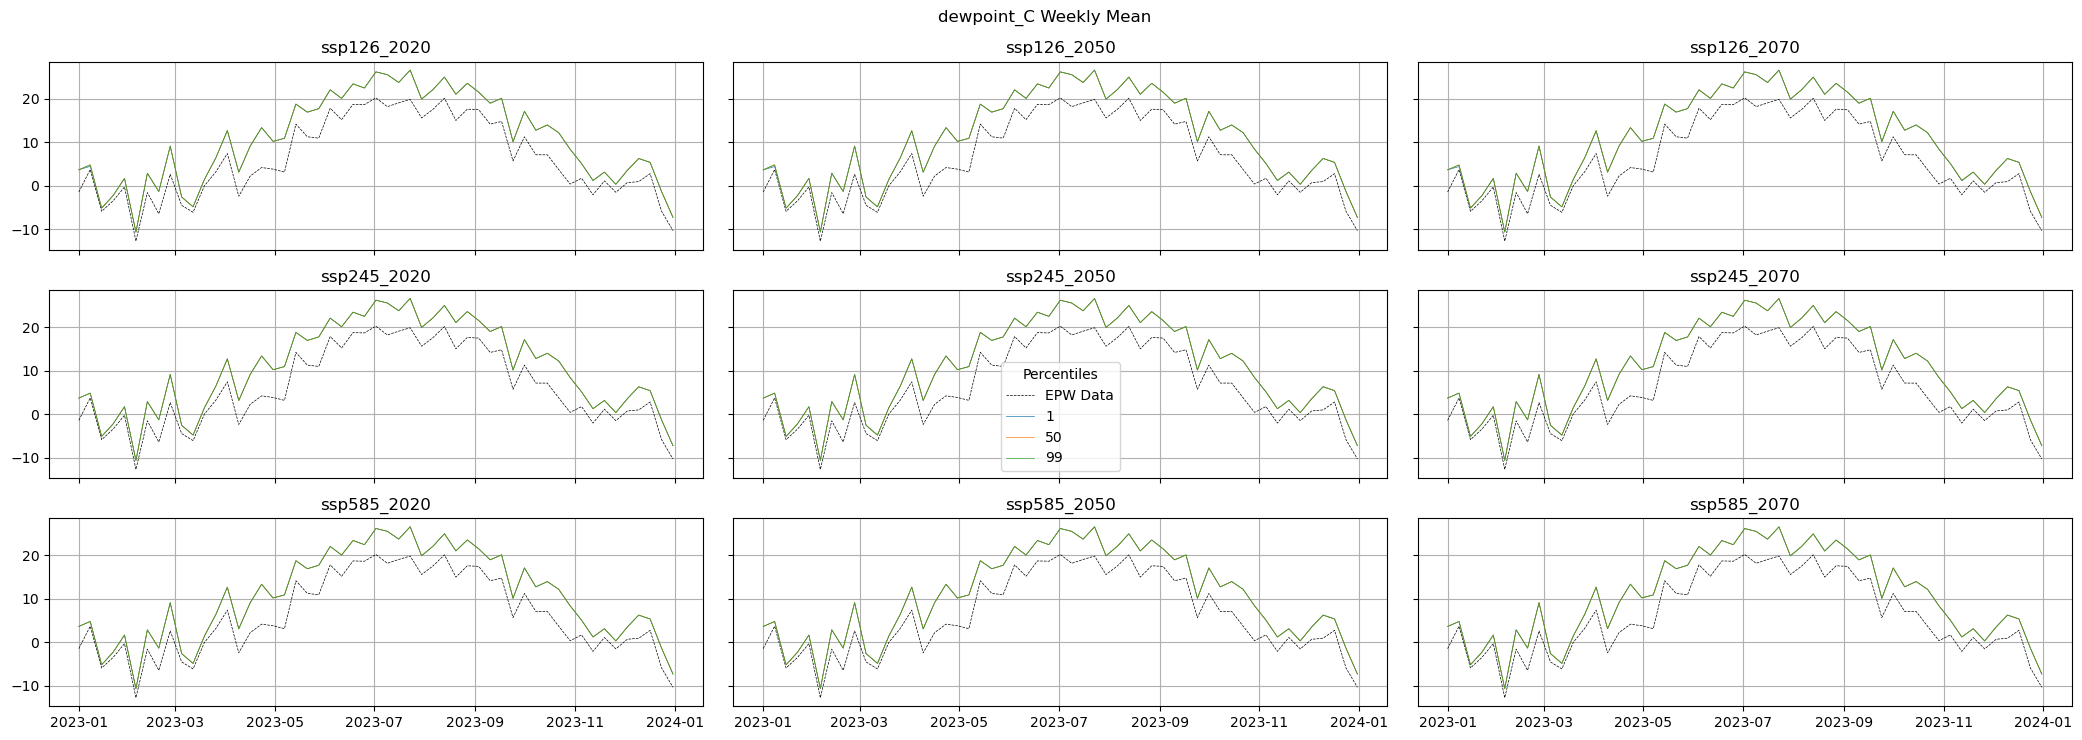

In [307]:
# lets plot the percentiles to see the range of warming
var = "dewpoint_C"

future_years = config_object.future_years
future_years.sort()
n_years = len(future_years) 

pathways = [pathway for pathway in config_object.model_pathways if pathway != "historical"]
pathways.sort()
n_pathways = len(pathways)

percentiles = config_object.percentiles
percentiles.sort()

# set up a figure where number of rows for number of pathways and number of columns for years
fig, axe = plt.subplots(n_pathways, n_years, 
                        sharex=True, sharey=True, 
                        figsize=(7*n_years,2.5*n_pathways)
                        )

# plot by pathway first
for p_n, pathway in enumerate(pathways):
    # then by year
    for y_n, year in enumerate(future_years):
        # set current subplot
        ax = axe[p_n,y_n]
        
        # plot the EPW series of data
        hist_data = config_object.epw.dataframe[var].resample("W").mean()
        ax.plot(hist_data,ls='dashed',color='k',lw=0.5, label='EPW Data')
        ax.title.set_text(f"{pathway}_{year}")
        
        # then multiple percentiles on the same plot
        for percentile in percentiles:
            plot_data = result_data[str(year)][pathway][str(percentile)].dataframe[var].resample("W").mean()
            ax.plot(plot_data, lw=0.5, label=percentile)
        ax.grid()
            
        
        

axe[1,1].legend(loc='lower center', title='Percentiles')
plt.suptitle(f"{var} Weekly Mean")
plt.tight_layout()